# **Mixed effect models**

This notebook is supplementary material for the paper "Harmonizing data from different soil organic matter fractionation protocols" by Kpemoua et al, 2025. 
We provide the code and data necessary for reproducing the paper's results, as well as several additional graphs and statistics not included in the paper (in the interest of brevity). 



### Setup

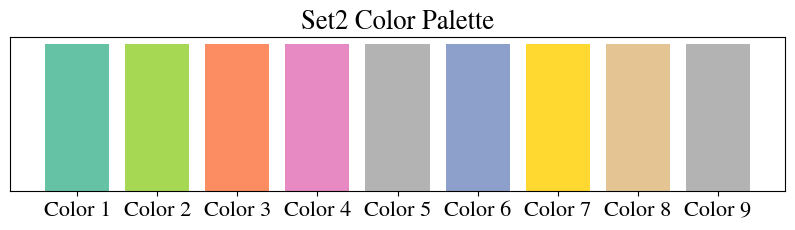

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import iqr
import scipy.stats as stats
import statsmodels.api as sm
import os
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings
import itertools
from scipy.stats import f_oneway, wilcoxon
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', ConvergenceWarning)


plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 16
# define custom colormaps
norm = matplotlib.colors.Normalize(-1,1)


################################################
############## ERROR FUNCTIONS #################
################################################

def rmspe_function (y_true, y_pred):
    return np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))


def rpd_function(y_true, y_pred):
    return np.std(y_true)/mean_squared_error(y_true, y_pred, squared=False)
# This function computes the Ratio of Performance to InterQuartile distance (RPIQ), which is defined as 
# interquartile range of the observed values divided by the Root Mean Square Error or Prediction (RMSEP). 


def rpiq_function  (y_true, y_pred):
    IQR = iqr(y_true)
    # RMSPE = rmspe_function(y_true=y_true, y_pred=y_pred)
    RMSE = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)
    return IQR/RMSE


def bias_function (y_true, y_pred):
    return y_pred.mean() - y_true.mean()

################################################
############### SET COLORS #####################
################################################
import matplotlib.pyplot as plt

# Set2 colors
colors = ['#66c2a5','#a6d854', '#fc8d62',  '#e78ac3', '#b3b3b3', '#8da0cb',  '#ffd92f', '#e5c494', '#b3b3b3']

# Plot each color as a horizontal bar
plt.figure(figsize=(10, 2))
for i, color in enumerate(colors):
    plt.bar(i, 1, color=color)

plt.xticks(range(len(colors)), labels=[f'Color {i+1}' for i in range(len(colors))])
plt.yticks([])
plt.title('Set2 Color Palette')
plt.show()
sns.set_palette(colors)

## **Read the data and plot distributions**

In [2]:
# ---- LOAD DATA ----
df = pd.read_csv('data/data_final.csv')

### PARAMETRIC TESTS ###
ANOVA: F = 4.420, p = 0.00174
Wilcoxon Signed-Rank (M1 vs. M2): W = 1.000, p = 0.00000

### VISUALIZATIONS ###


/tmp/ipykernel_736262/4191508895.py:36: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  ax = sns.boxplot(x="Protocol", y="Value", data=df1, palette=colors, hue='Protocol', legend=False)


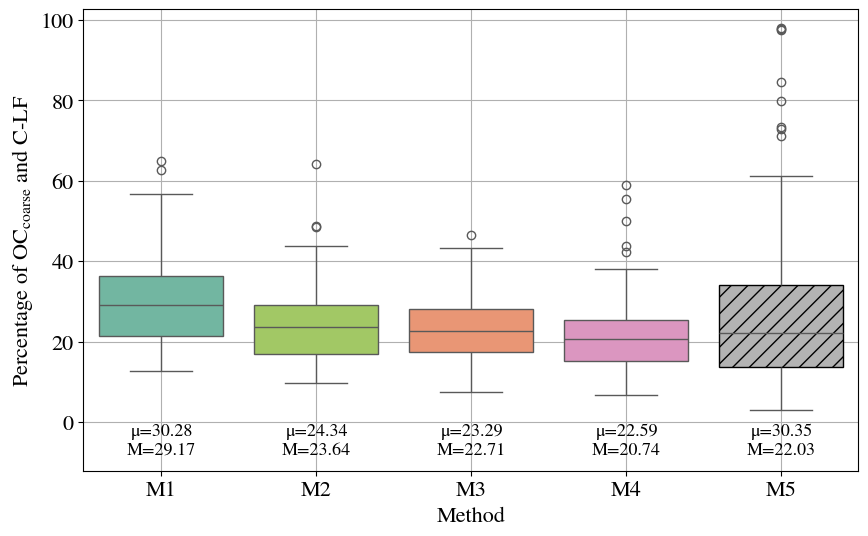

In [3]:
var='prop_POC'

methods = sorted(df['method'].unique())

np.random.seed(42)
M1 = df[df['method'] == 'M1'][var]
M2 = df[df['method'] == 'M2'][var]
M3 = df[df['method'] == 'M3'][var]
M4 = df[df['method'] == 'M4'][var]
M5 = df[df['method'] == 'M5'][var]

# Combine data
protocols = ['M1', 'M2', 'M3', 'M4', 'M5']
data_explore = [M1, M2, M3, M4, M5]
all_values = np.concatenate(data_explore)
group_labels = np.concatenate([[protocols[i]] * len(data_explore[i]) for i in range(len(protocols))])

df1 = pd.DataFrame({'Protocol': group_labels, 'Value': all_values})

# 1. Parametric Tests
print("### PARAMETRIC TESTS ###")

# ANOVA
anova_stat, anova_p = f_oneway(M1, M2, M3, M4, M5)
print(f"ANOVA: F = {anova_stat:.3f}, p = {anova_p:.5f}")

# Wilcoxon Signed-Rank Test (M1 vs. M2, Paired Data)
wilcoxon_stat, wilcoxon_p = wilcoxon(M1[:20], M2[:20])  # Taking first 20 samples to match sizes
print(f"Wilcoxon Signed-Rank (M1 vs. M2): W = {wilcoxon_stat:.3f}, p = {wilcoxon_p:.5f}")

# 4. Visualizations
print("\n### VISUALIZATIONS ###")

# Boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="Protocol", y="Value", data=df1, palette=colors, hue='Protocol', legend=False)

# Loop through the boxes (they’re PathPatch objects)
for i, patch in enumerate(ax.patches):
    if i == len(protocols) - 1:  # last box only
        # Base box (black outline)
        # patch.set_facecolor("white")
        patch.set_edgecolor("black")
        patch.set_hatch("//")


plt.xlabel('Method')
plt.ylabel('Percentage of OC$_\mathrm{coarse}$ and C-LF')
plt.grid()


group_stats = df.groupby('method')[var].agg(['mean', 'median']).round(2)
positions = dict(zip(methods, range(len(methods))))
for method, pos in positions.items():
    mean_val = group_stats.loc[method, 'mean']
    median_val = group_stats.loc[method, 'median']
    ax.text(pos, ax.get_ylim()[0] - (ax.get_ylim()[1] * 0.05) - (ax.get_ylim()[1] * 0.01),
            f"μ={mean_val}\nM={median_val}", 
            ha='center', fontsize=13, color='black')
    
y_lower, y_upper = ax.get_ylim()

# Increase the lower limit to add more space for annotations
y_lower_new = y_lower - (y_upper - y_lower) * 0.1  # Adding 10% space below
ax.set_ylim(y_lower_new, y_upper)

# plt.savefig('paper/figures/prop_poc_barplot1.png', bbox_inches='tight')
plt.show()

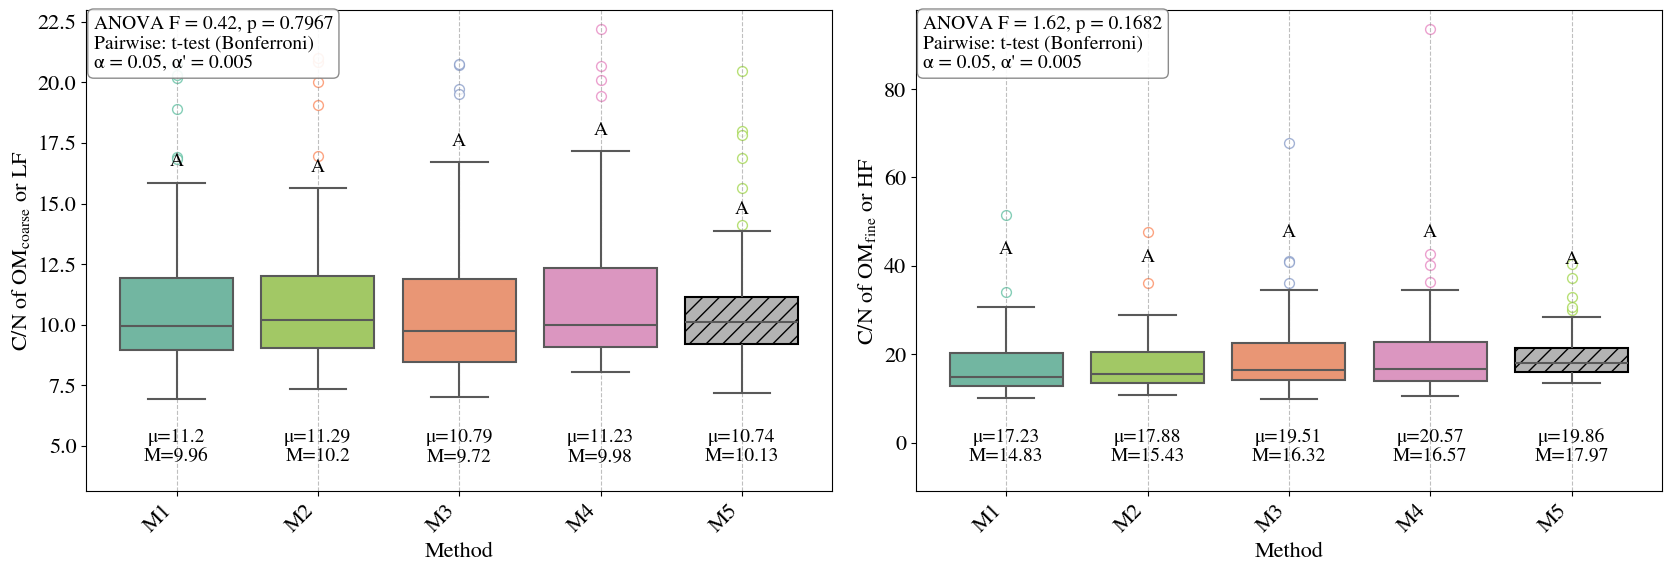

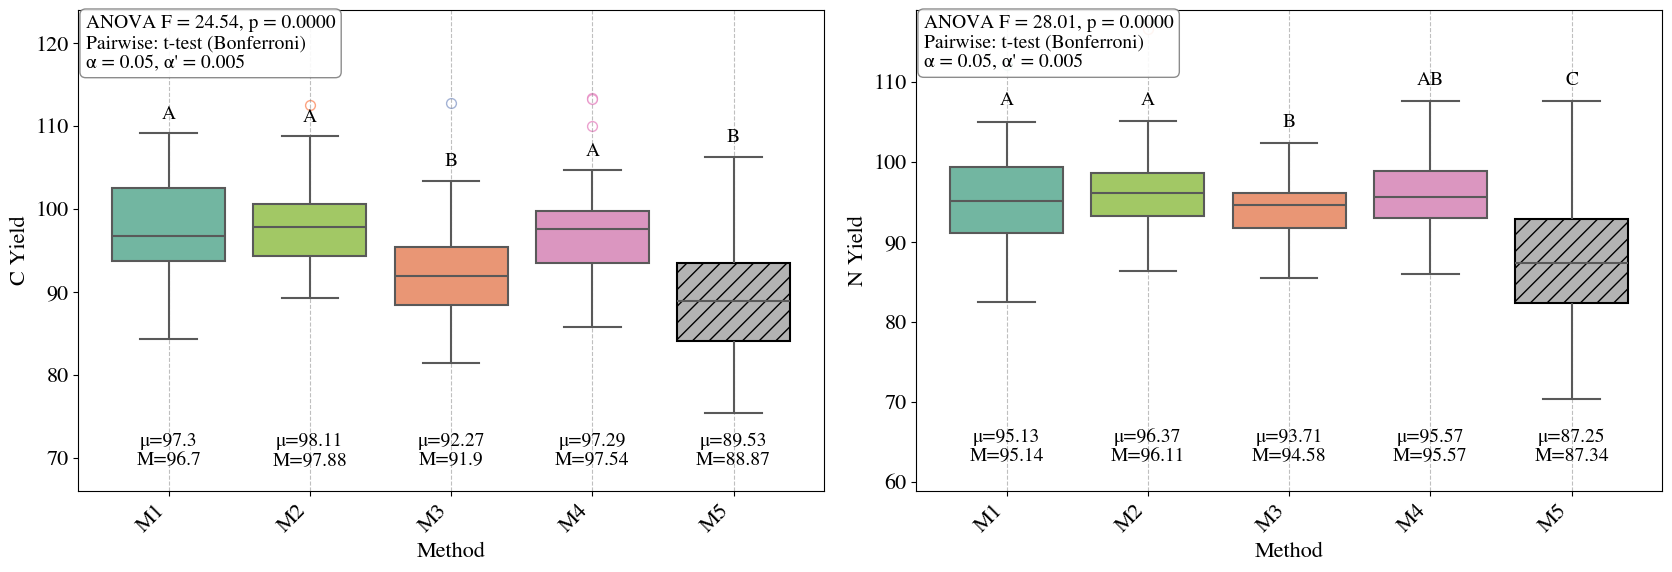

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, f_oneway
from itertools import combinations

names = {
    'C_N_MAOC' : 'C/N of OM$_\mathrm{coarse}$ or LF',
    'C_N_POC' : 'C/N of OM$_\mathrm{fine}$ or HF',
    'yield_C' : 'C Yield',
    'yield_N' : 'N Yield'
}

# === Compact Letter Display helper ===
def get_group_letters(reject, pairs, groups):
    sig_pairs = set()
    for (i, j), sig in zip(pairs.T, reject):
        if sig:
            sig_pairs.add((groups[i], groups[j]))
            sig_pairs.add((groups[j], groups[i]))

    letters = {g: "" for g in groups}
    bins = []
    current_letter = "A"

    for g in groups:
        placed = False
        for b_idx, b in enumerate(bins):
            if all((g, h) not in sig_pairs for h in b):
                b.append(g)
                letters[g] += chr(ord("A") + b_idx)
                placed = True
        if not placed:
            bins.append([g])
            letters[g] += current_letter
            current_letter = chr(ord(current_letter) + 1)

    return letters

# === Whisker & outlier computation ===
def whisker_top_and_outliers(series):
    s = series.dropna()
    if s.empty:
        return np.nan, s
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    within = s[s <= upper_bound]
    upper_whisker = within.max() if not within.empty else s.max()
    outliers = s[s > upper_bound]
    return upper_whisker, outliers

# === Plot pairs of variables side by side ===
variables_pairs = [
    ['C_N_MAOC', 'C_N_POC'],  # C/N ratios
    ['yield_C', 'yield_N']     # yields
]

for var_group in variables_pairs:
    fig, axes = plt.subplots(1, 2, figsize=(17, 6), sharey=False)
    for ax, var in zip(axes, var_group):
        # special filtering for C_N_POC
        if var == 'C_N_POC':
            df_copy = df.copy()
            df = df[df['C_N_POC'] < 1000]

        methods = sorted(df['method'].unique())
        palette_list = sns.color_palette("Set2", n_colors=len(methods))
        palette = dict(zip(methods, palette_list))

        ax = sns.boxplot(
            data=df, 
            x='method', 
            y=var,
            order=methods, 
            showfliers=False,
            linewidth=1.5,
            zorder=2,
            ax=ax,
            hue='method',
            legend=False,
            palette=colors[0:len(methods)],
        )
        # Loop through the boxes (they’re PathPatch objects)
        for i, patch in enumerate(ax.patches):
            if i == len(protocols) - 1:  # last box only
                # Base box (black outline)
                # patch.set_facecolor("white")
                patch.set_edgecolor("black")
                patch.set_hatch("//")

        positions = dict(zip(methods, range(len(methods))))
        upper_whiskers = {}
        outliers_by_group = {}

        for m in methods:
            s = df.loc[df['method'] == m, var]
            uw, outs = whisker_top_and_outliers(s)
            upper_whiskers[m] = uw
            outliers_by_group[m] = outs

        rng = np.random.default_rng(42)
        jitter_scale = 0.00
        for m in methods:
            outs = outliers_by_group[m]
            if outs.size > 0:
                x_pos = positions[m]
                xs = rng.normal(loc=x_pos, scale=jitter_scale, size=outs.size)
                ax.scatter(xs, outs.values, s=50, marker='o',
                           facecolor='white', edgecolor=palette[m], linewidths=1, zorder=1, alpha=0.8)

        group_stats = df.groupby('method')[var].agg(['mean', 'median']).round(2)
        y_low0, y_high0 = ax.get_ylim()
        extra_bottom = (y_high0 - y_low0) * 0.18
        step = (y_high0 - y_low0) * 0.03

        combos = list(combinations(methods, 2))
        alpha = 0.05
        corrected_alpha = alpha / len(combos) if len(combos) > 0 else alpha
        pvals = []
        for m1, m2 in combos:
            d1 = df.loc[df['method'] == m1, var].dropna()
            d2 = df.loc[df['method'] == m2, var].dropna()
            stat, pval = ttest_ind(d1, d2, equal_var=False)
            pvals.append(pval)
        reject = np.array([p < corrected_alpha for p in pvals]) if pvals else np.array([])
        pairs = (np.array([[methods.index(m1), methods.index(m2)] for m1, m2 in combos]).T
                 if combos else np.empty((2, 0), dtype=int))
        letters_dict = get_group_letters(reject, pairs, np.array(methods)) if combos else {m: "A" for m in methods}

        top_needed = max((upper_whiskers[m] if np.isfinite(upper_whiskers[m]) else y_high0) + step for m in methods)
        y_top_final = max(y_high0, top_needed + step)
        if var == 'yield_C':
            y_top_final = y_top_final + step*7
        y_bottom_final = y_low0 - extra_bottom
        ax.set_ylim(y_bottom_final, y_top_final)

        text_y = y_low0 - (extra_bottom * 0.65)
        for m, pos in positions.items():
            mean_val = group_stats.loc[m, 'mean']
            median_val = group_stats.loc[m, 'median']
            ax.text(pos, text_y, f"μ={mean_val}\nM={median_val}",
                    ha='center', va='bottom', fontsize=14, color='black')

        for m, pos in positions.items():
            uw = upper_whiskers[m]
            if np.isfinite(uw):
                if var == 'C_N_POC':
                    ax.text(pos, uw + 4*step, letters_dict[m],
                        ha='center', va='bottom', fontsize=14, color='black')
                else:
                    ax.text(pos, uw + step, letters_dict[m],
                        ha='center', va='bottom', fontsize=14, color='black')

        groups_for_anova = [df.loc[df['method'] == m, var].dropna() for m in methods]
        if all(len(g) > 0 for g in groups_for_anova) and len(groups_for_anova) > 1:
            f_stat, pval_anova = f_oneway(*groups_for_anova)
        else:
            f_stat, pval_anova = np.nan, np.nan
        note = (
            f"ANOVA F = {f_stat:.2f}, p = {pval_anova:.4f}\n"
            f"Pairwise: t-test (Bonferroni)\n"
            f"α = {alpha}, α' = {corrected_alpha:.3g}"
        )
        ax.text(
            0.01, 0.99, note,
            transform=ax.transAxes, ha='left', va='top',
            fontsize=14,
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.5', alpha=0.9)
        )

        ax.set_xlabel('Method')
        ax.set_ylabel(names[var])
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        ax.grid(axis='x', linestyle='--', color='gray', alpha=0.5)

        if var == 'C_N_POC':
            df = df_copy

    plt.tight_layout()
    # plt.savefig(f'paper/figures/boxplot_{"_".join(var_group)}.png', bbox_inches='tight')
    plt.show()


## **LMM Linear Mixed Models**

### Auxiliary functions

In [5]:
# ---- FUNCTION FOR RESIDUAL ANALYSIS ----
def residual_analysis(model_entry, methods, folder):
    import scipy.stats as stats

    residuals = model_entry['data']['diff'] - model_entry['data']['predicted_diff']

    # Q-Q plot
    plt.figure(figsize=(6,6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Residuals ({model_entry['model_type']})")
    plt.grid(True)
    qq_save_path = f'{folder}/qqplot_residuals_{"".join(methods)}_{model_entry["model_type"]}.png'
    plt.savefig(qq_save_path, bbox_inches='tight')
    plt.close()

    # Histogram of residuals
    plt.figure(figsize=(8,5))
    sns.histplot(residuals, kde=True, bins=20)
    plt.title(f"Histogram of Residuals ({model_entry['model_type']})")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.grid(True)
    hist_save_path = f'{folder}/hist_residuals_{"".join(methods)}_{model_entry["model_type"]}.png'
    plt.savefig(hist_save_path, bbox_inches='tight')
    plt.close()

    # Normality tests
    shapiro_test = stats.shapiro(residuals)
    dagostino_test = stats.normaltest(residuals)

    print(f"\nNormality tests for residuals ({model_entry['model_type']}, methods {methods}):")
    print(f"Shapiro-Wilk test: Statistic={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4f}")
    print(f"D'Agostino K^2 test: Statistic={dagostino_test.statistic:.4f}, p-value={dagostino_test.pvalue:.4f}")


In [6]:
# ---- FUNCTION TO GENERATE ALL COMBINATIONS OF PREDICTORS ----
predictors = ['pH', 'Clay', 'TOC_mesured']

def generate_all_combinations_full_fixed(predictors):
    formulas = ['diff ~ 0 + C(protocol_combination)']

    n = len(predictors)

    # All subsets for additive terms (size 0..n)
    additive_subsets = []
    for r in range(n+1):
        additive_subsets.extend(itertools.combinations(predictors, r))

    # # If you want to include interaction terms, uncomment the following lines
    # # We will not include interaction terms in this version because they are not needed for the current analysis and can complicate the model unnecessarily
    # # All subsets for interaction terms (size >=2)
    # interaction_subsets = []
    # for r in range(2, n+1):
    #     interaction_subsets.extend(itertools.combinations(predictors, r))

    # # Combine additive + interaction subsets
    # for add in additive_subsets:
    #     for inter in interaction_subsets:
    #         # Avoid duplication: skip if interaction is fully contained in additive
    #         if set(inter).issubset(add):
    #             continue
    #         formula = 'method'
    #         if inter:
    #             formula += ' + ' + '*'.join(inter)
    #         if add:
    #             formula += ' + ' + ' + '.join(add)
    #         formulas.append(formula)


    # Also include all purely additive combinations (already included in loop, but safe to add)
    for add in additive_subsets:
        if add:
            formula = 'diff ~ 0 + C(protocol_combination) + ' + ' + '.join(add)
            formulas.append(formula)

            formula = 'diff ~ 0 + ' + ' + '.join(add)
            formulas.append(formula)

    # Remove duplicates
    return sorted(list(set(formulas)))

In [ ]:
# ---- FUNCTION TO MERGE AND COMPARE METHODS ----
def compare_methods(filtered_df, methods, var = 'prop_POC'):
    m1, m2 = methods
    df1 = filtered_df[filtered_df['method'] == m1]
    df2 = filtered_df[filtered_df['method'] == m2]
    merged = pd.merge(df1, df2, on='ID', suffixes=('_1', '_2'))
    merged['protocol_combination'] = f"{m1}{m2}"
    merged['diff'] = merged[var+'_1'] - merged[var+'_2']

    merged = merged.rename(columns={
        'Clay_1': 'Clay',
        'pH_1': 'pH',
        'TOC_1': 'TOC',
        'num_ID_1': 'num_ID',
        'TOC_mesured_1': 'TOC_mesured',
        'TIC_1': 'TIC',
    })
    return merged

### Main modeling section

                          model_type         AIC        AICC         BIC  \
0                             method  348.730527  348.937424  355.063149   
4                        method + pH  346.792084  347.213137  355.235580   
3               method + TOC_mesured  347.800200  348.221252  356.243695   
7          method + pH + TOC_mesured  346.608665  347.322950  357.163034   
1                      method + Clay  349.847575  350.268628  358.291071   
2        method + Clay + TOC_mesured  348.336248  349.050534  358.890617   
5                 method + pH + Clay  348.602587  349.316873  359.156956   
6   method + pH + Clay + TOC_mesured  348.075292  349.166201  360.740535   
14                + pH + TOC_mesured  353.709601  354.130654  362.153097   
11                              + pH  357.794565  358.001462  364.127187   
13         + pH + Clay + TOC_mesured  354.866963  355.581248  365.421332   
12                       + pH + Clay  359.582542  360.003595  368.026038   
9           

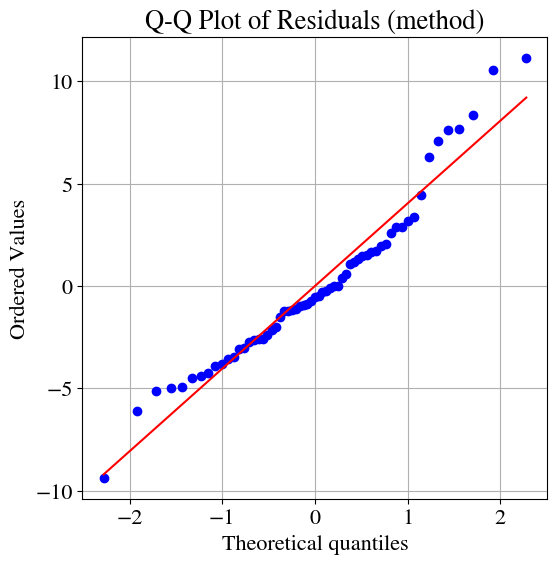

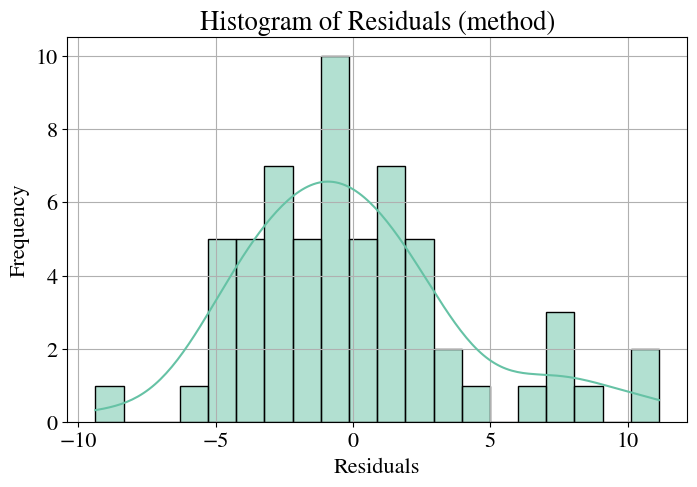


Normality tests for residuals (method):
Shapiro-Wilk test: Statistic=0.9535, p-value=0.0212 -> ❌ Not normal
D'Agostino K^2 test: Statistic=7.1402, p-value=0.0282 -> ❌ Not normal
                          model_type         AIC        AICC         BIC  \
5                 method + pH + Clay  378.415951  379.130237  388.970321   
6   method + pH + Clay + TOC_mesured  377.005848  378.096757  389.671091   
4                        method + pH  383.924673  384.345726  392.368169   
7          method + pH + TOC_mesured  384.477884  385.192169  395.032253   
2        method + Clay + TOC_mesured  393.388551  394.102836  403.942920   
1                      method + Clay  397.014869  397.435922  405.458365   
0                             method  407.138572  407.345468  413.471194   
3               method + TOC_mesured  406.406775  406.827827  414.850270   
13         + pH + Clay + TOC_mesured  407.556297  408.270583  418.110666   
14                + pH + TOC_mesured  413.319148  413.740200 

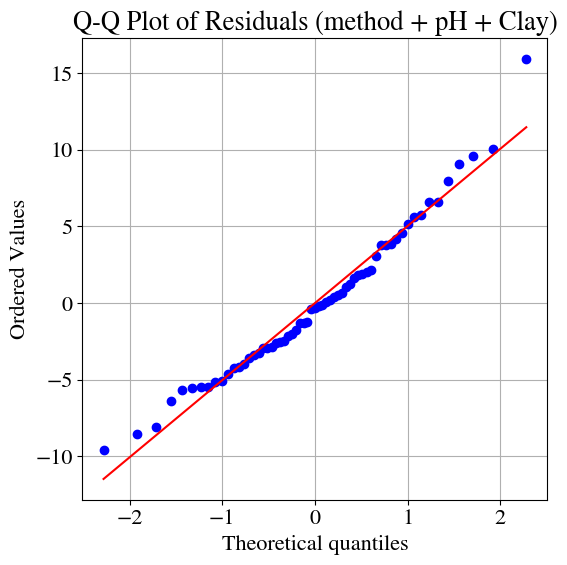

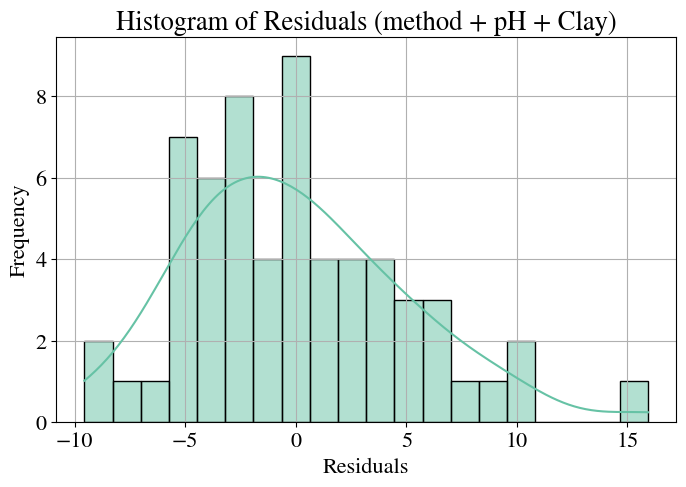


Normality tests for residuals (method + pH + Clay):
Shapiro-Wilk test: Statistic=0.9719, p-value=0.1733 -> ✅ Normal
D'Agostino K^2 test: Statistic=5.9023, p-value=0.0523 -> ✅ Normal
                          model_type         AIC        AICC         BIC  \
0                             method  417.209510  417.416406  423.542131   
11                              + pH  419.446432  419.653328  425.779053   
1                      method + Clay  419.139943  419.560996  427.583438   
3               method + TOC_mesured  419.148780  419.569832  427.592275   
4                        method + pH  419.154218  419.575271  427.597714   
14                + pH + TOC_mesured  420.940366  421.361418  429.383861   
12                       + pH + Clay  421.354029  421.775082  429.797525   
5                 method + pH + Clay  421.038117  421.752403  431.592486   
2        method + Clay + TOC_mesured  421.094558  421.808844  431.648927   
7          method + pH + TOC_mesured  421.108393  421.822

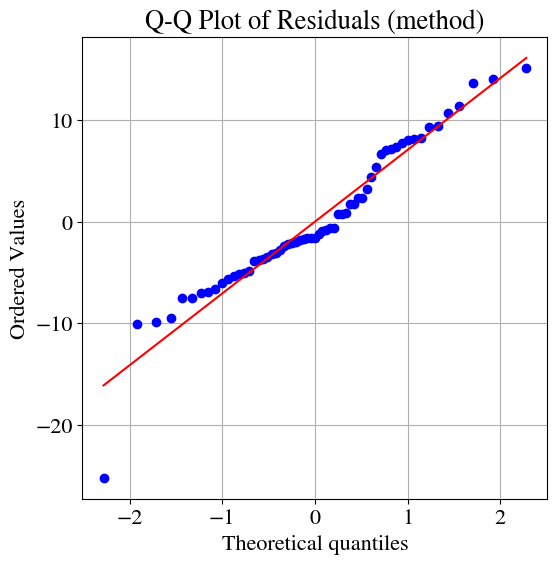

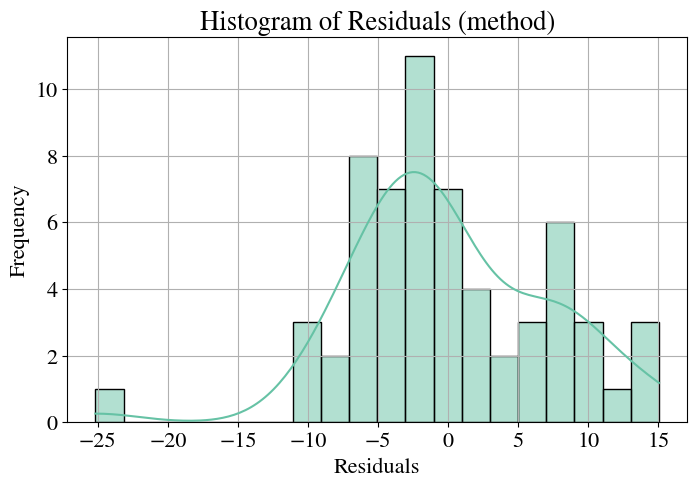


Normality tests for residuals (method):
Shapiro-Wilk test: Statistic=0.9510, p-value=0.0161 -> ❌ Not normal
D'Agostino K^2 test: Statistic=4.6201, p-value=0.0993 -> ✅ Normal
                          model_type         AIC        AICC         BIC  \
1                      method + Clay  540.358291  540.779344  548.801787   
12                       + pH + Clay  541.319631  541.740684  549.763127   
5                 method + pH + Clay  542.351879  543.066165  552.906249   
2        method + Clay + TOC_mesured  542.356511  543.070797  552.910881   
13         + pH + Clay + TOC_mesured  543.218679  543.932965  553.773049   
8                             + Clay  550.383824  550.590720  556.716445   
6   method + pH + Clay + TOC_mesured  544.351139  545.442048  557.016382   
9               + Clay + TOC_mesured  549.382915  549.803968  557.826411   
10                     + TOC_mesured  554.107546  554.314442  560.440167   
11                              + pH  554.178438  554.385335  560

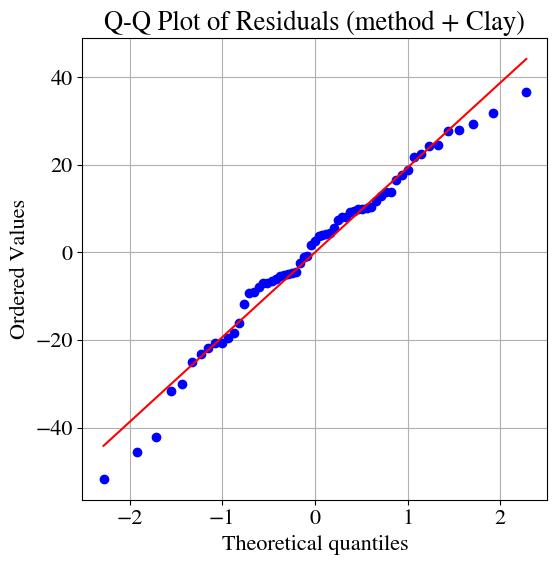

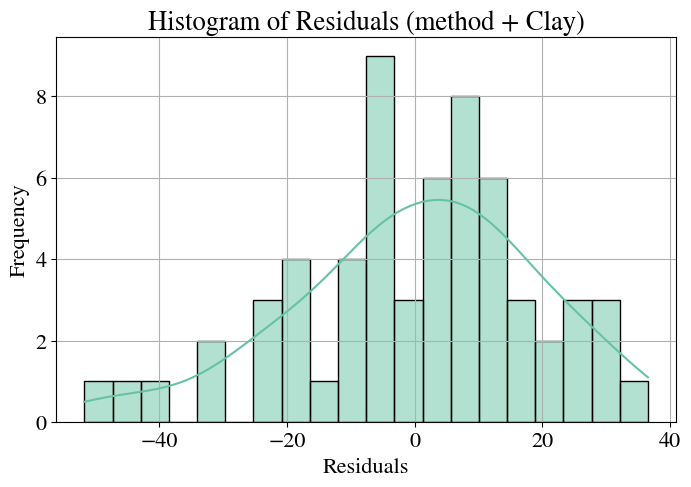


Normality tests for residuals (method + Clay):
Shapiro-Wilk test: Statistic=0.9761, p-value=0.2751 -> ✅ Normal
D'Agostino K^2 test: Statistic=3.2025, p-value=0.2016 -> ✅ Normal
                          model_type         AIC        AICC         BIC  \
5                 method + pH + Clay  346.901978  347.616264  357.456348   
6   method + pH + Clay + TOC_mesured  348.317948  349.408857  360.983191   
4                        method + pH  354.467510  354.888563  362.911006   
7          method + pH + TOC_mesured  356.445880  357.160165  367.000249   
1                      method + Clay  362.780588  363.201640  371.224083   
2        method + Clay + TOC_mesured  362.765467  363.479752  373.319836   
9               + Clay + TOC_mesured  369.286913  369.707965  377.730408   
13         + pH + Clay + TOC_mesured  368.899509  369.613794  379.453878   
12                       + pH + Clay  371.982822  372.403875  380.426317   
10                     + TOC_mesured  374.517961  374.724857  

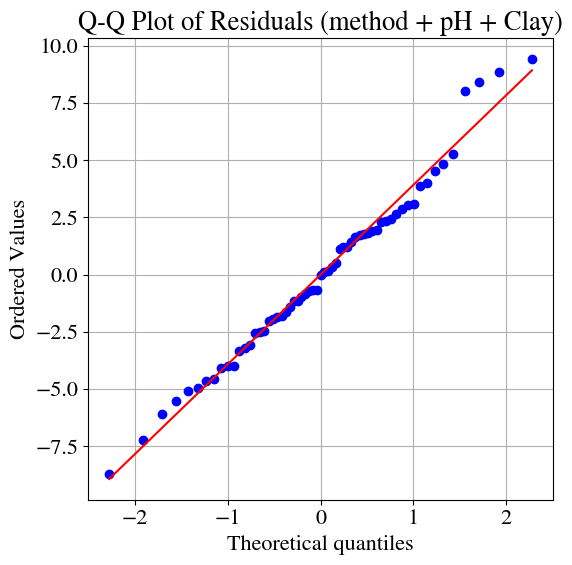

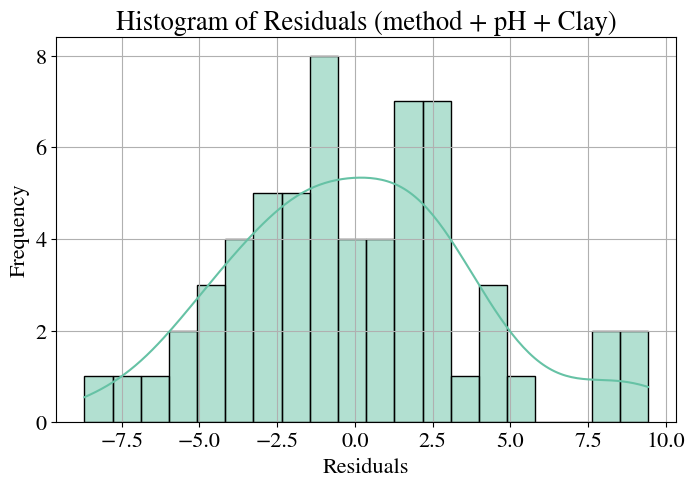


Normality tests for residuals (method + pH + Clay):
Shapiro-Wilk test: Statistic=0.9831, p-value=0.5635 -> ✅ Normal
D'Agostino K^2 test: Statistic=1.3777, p-value=0.5022 -> ✅ Normal
                          model_type         AIC        AICC         BIC  \
8                             + Clay  399.600540  399.807437  405.933162   
11                              + pH  399.719074  399.925970  406.051695   
0                             method  400.304970  400.511867  406.637592   
14                + pH + TOC_mesured  400.953644  401.374697  409.397139   
9               + Clay + TOC_mesured  401.215526  401.636578  409.659021   
12                       + pH + Clay  401.250160  401.671213  409.693655   
4                        method + pH  401.276992  401.698044  409.720487   
10                     + TOC_mesured  403.388503  403.595400  409.721125   
1                      method + Clay  401.459432  401.880485  409.902927   
3               method + TOC_mesured  401.619951  402.041

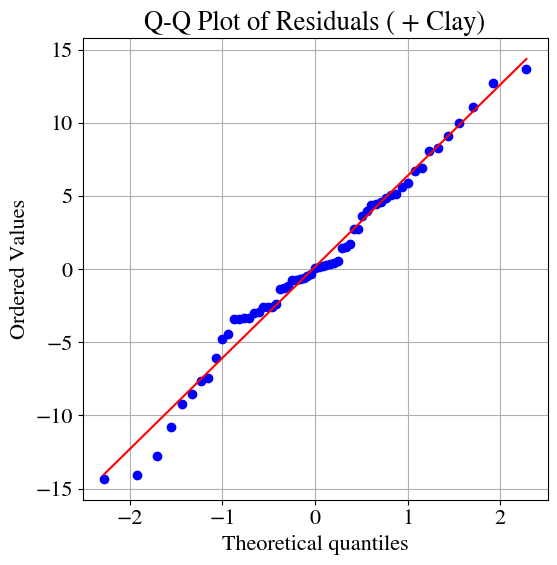

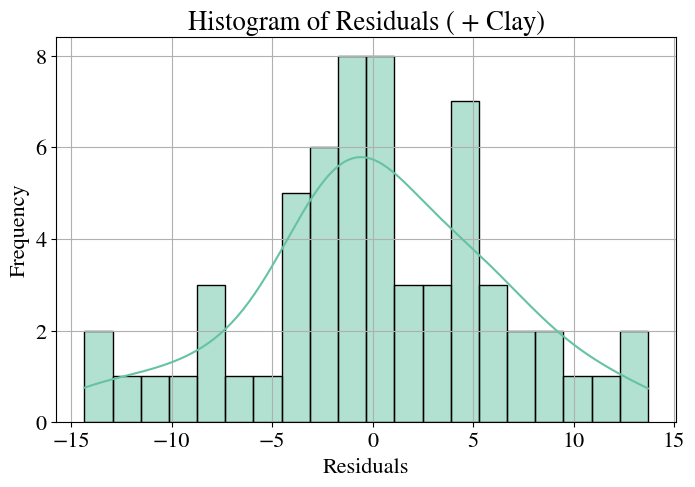


Normality tests for residuals ( + Clay):
Shapiro-Wilk test: Statistic=0.9826, p-value=0.5343 -> ✅ Normal
D'Agostino K^2 test: Statistic=0.6229, p-value=0.7324 -> ✅ Normal
                          model_type         AIC        AICC         BIC  \
1                      method + Clay  534.188974  534.610026  542.632469   
12                       + pH + Clay  537.450507  537.871559  545.894002   
2        method + Clay + TOC_mesured  536.056858  536.771143  546.611227   
5                 method + pH + Clay  536.093979  536.808265  546.648348   
13         + pH + Clay + TOC_mesured  538.608077  539.322363  549.162446   
6   method + pH + Clay + TOC_mesured  537.997961  539.088870  550.663204   
0                             method  550.906769  551.113665  557.239390   
11                              + pH  551.873507  552.080404  558.206129   
9               + Clay + TOC_mesured  550.582579  551.003632  559.026075   
10                     + TOC_mesured  553.012390  553.219287  559.34

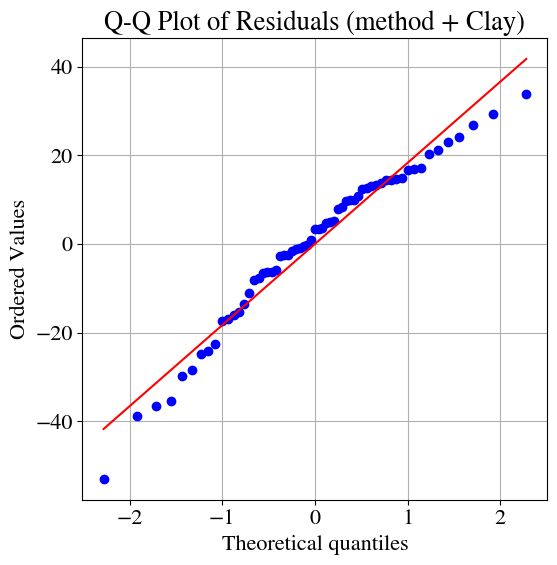

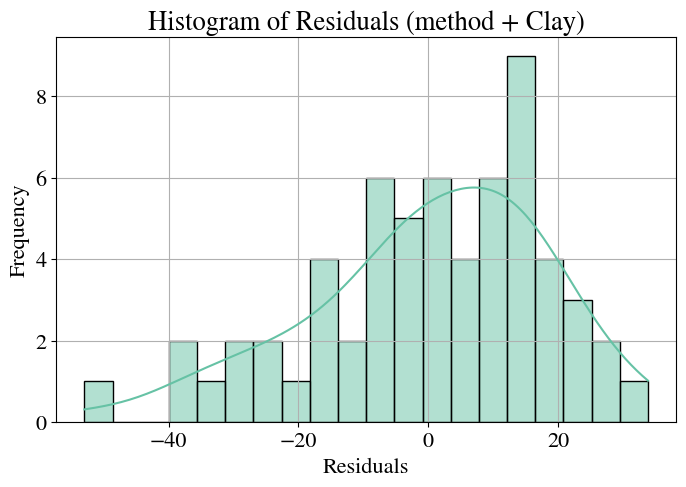


Normality tests for residuals (method + Clay):
Shapiro-Wilk test: Statistic=0.9647, p-value=0.0760 -> ✅ Normal
D'Agostino K^2 test: Statistic=5.2553, p-value=0.0722 -> ✅ Normal
                          model_type         AIC        AICC         BIC  \
5                 method + pH + Clay  377.082825  377.797110  387.637194   
6   method + pH + Clay + TOC_mesured  376.400612  377.491521  389.065855   
4                        method + pH  385.364866  385.785918  393.808361   
7          method + pH + TOC_mesured  386.550588  387.264874  397.104957   
9               + Clay + TOC_mesured  390.341647  390.762699  398.785142   
2        method + Clay + TOC_mesured  390.153214  390.867500  400.707583   
1                      method + Clay  392.886075  393.307127  401.329570   
13         + pH + Clay + TOC_mesured  392.297547  393.011833  402.851917   
8                             + Clay  399.368126  399.575022  405.700747   
12                       + pH + Clay  398.680287  399.101340  

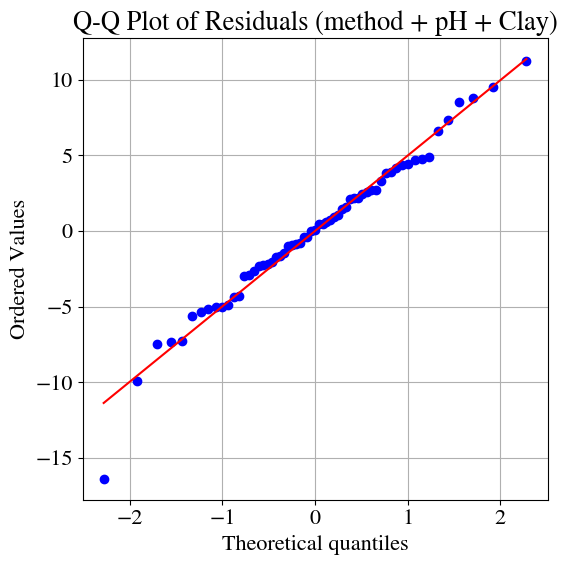

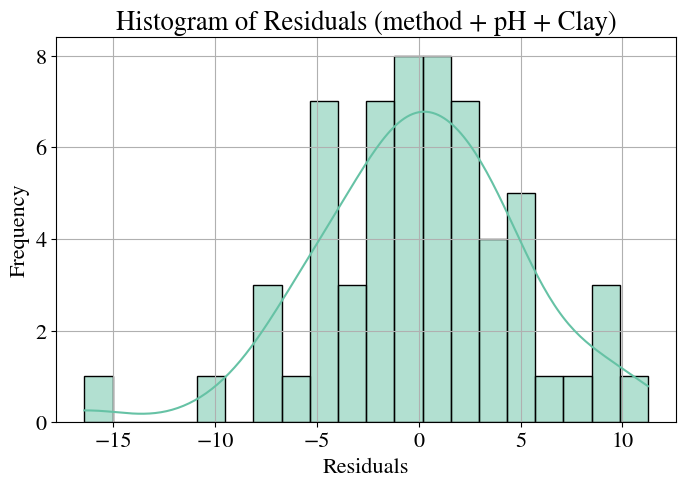


Normality tests for residuals (method + pH + Clay):
Shapiro-Wilk test: Statistic=0.9815, p-value=0.4819 -> ✅ Normal
D'Agostino K^2 test: Statistic=4.3953, p-value=0.1111 -> ✅ Normal
                          model_type         AIC        AICC         BIC  \
1                      method + Clay  543.241127  543.662179  551.684622   
5                 method + pH + Clay  543.825552  544.539838  554.379922   
2        method + Clay + TOC_mesured  544.806545  545.520831  555.360914   
12                       + pH + Clay  549.733592  550.154645  558.177088   
6   method + pH + Clay + TOC_mesured  545.629439  546.720348  558.294683   
13         + pH + Clay + TOC_mesured  549.906860  550.621145  560.461229   
4                        method + pH  561.321244  561.742296  569.764739   
9               + Clay + TOC_mesured  561.902558  562.323611  570.346054   
0                             method  564.036136  564.243032  570.368757   
11                              + pH  565.544695  565.751

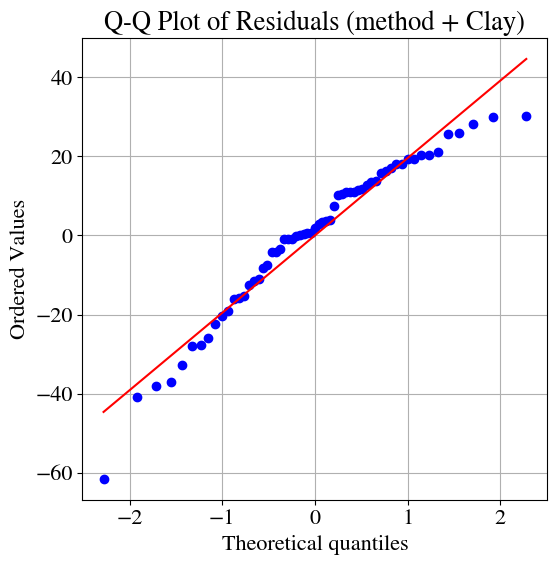

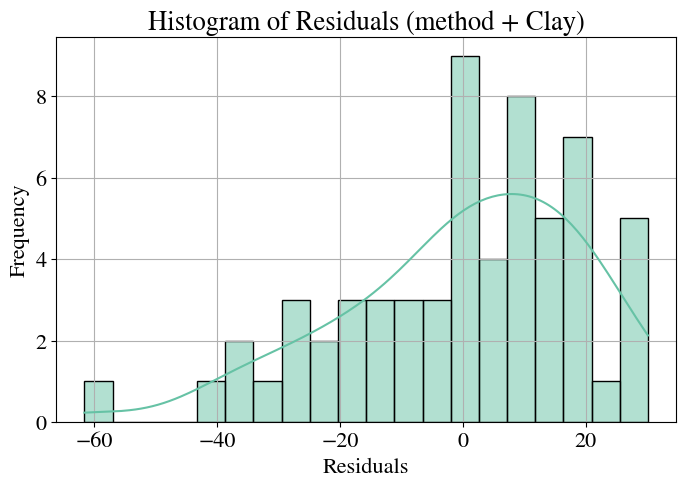


Normality tests for residuals (method + Clay):
Shapiro-Wilk test: Statistic=0.9509, p-value=0.0159 -> ❌ Not normal
D'Agostino K^2 test: Statistic=7.3212, p-value=0.0257 -> ❌ Not normal
                          model_type         AIC        AICC         BIC  \
1                      method + Clay  534.909255  535.330307  543.352750   
12                       + pH + Clay  537.499152  537.920205  545.942648   
5                 method + pH + Clay  536.907674  537.621959  547.462043   
2        method + Clay + TOC_mesured  536.907784  537.622070  547.462154   
13         + pH + Clay + TOC_mesured  539.154729  539.869014  549.709098   
6   method + pH + Clay + TOC_mesured  538.906698  539.997607  551.571941   
0                             method  549.350136  549.557032  555.682757   
11                              + pH  550.442353  550.649249  556.774974   
4                        method + pH  550.203978  550.625031  558.647473   
3               method + TOC_mesured  551.122327  551.

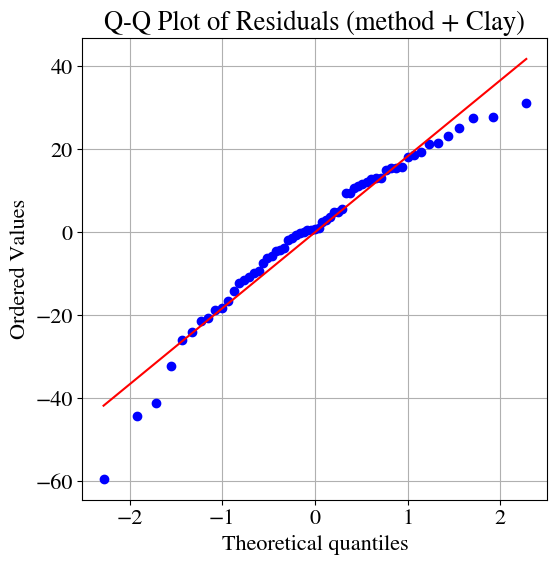

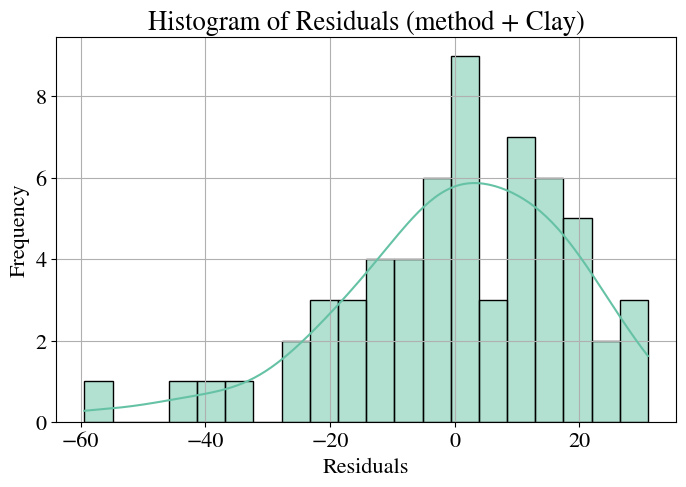


Normality tests for residuals (method + Clay):
Shapiro-Wilk test: Statistic=0.9565, p-value=0.0297 -> ❌ Not normal
D'Agostino K^2 test: Statistic=9.5407, p-value=0.0085 -> ❌ Not normal


In [8]:
# ---- CONFIG ----
method_combinations = [['M1', 'M2'], ['M1', 'M3'], ['M1', 'M4'], ['M1', 'M5'], ['M2', 'M3'], ['M2', 'M4'], ['M2', 'M5'], ['M3', 'M4'], ['M3', 'M5'], ['M4', 'M5']]
predictors = ['pH', 'Clay', 'TOC_mesured']
model_types = generate_all_combinations_full_fixed(['pH', 'Clay', 'TOC_mesured'])

# ---- LOAD DATA ----
df = pd.read_csv('data/data_final.csv')

# ---- MAIN LOOP ----
metrics_rows = []
aic_bic_results_full = {}
fitted_models_full = {}
df_compare_combined = pd.DataFrame()

for methods in method_combinations:
    folder = 'output/figures'
    os.makedirs(folder, exist_ok=True)

    var = 'prop_POC'
    aic_bic_results = []
    fitted_models = {}

    for ph_outliers in [False]:  # ph_outlier_flags:
        df_compare = compare_methods(df, methods, var)
        df_compare_combined = pd.concat([df_compare_combined, df_compare], ignore_index=True)

        for model_type in model_types:
            method_data = df_compare.copy()
            model = smf.mixedlm(model_type, method_data.dropna(), groups=method_data['num_ID'])
            result = model.fit(reml=False, maxiter=5000, tol=1e-8, method='bfgs')
            method_data['predicted_diff'] = result.predict(method_data)
            fitted_models[model_type] = result

            method_data['corrected_'+var+'_2'] = method_data[var+'_2'] + method_data['predicted_diff']

            # PLOT
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x=method_data[var+'_1'], y=method_data['corrected_'+var+'_2'], label='Corrected', s=100)
            sns.scatterplot(x=method_data[var+'_1'], y=method_data[var+'_2'], label='Original', alpha=0.5, s=100)
            sns.lineplot(x=[0, 100], y=[0, 100], color='gray', linestyle='--')


            # Store AIC/BIC
            aic_bic_results.append({
                'methods': methods,
                'model_type': model_type.replace('diff ~ 0 + C(protocol_combination)', 'method').replace('diff ~ 0',''),
                'ph_outliers': ph_outliers,
                'AIC': result.aic,
                'AICC' : result.aic + (2 * len(result.params) * (len(result.params) + 1)) / ((len(method_data) - len(result.params) - 1)),
                'BIC': result.bic,
                'RMSE' : np.sqrt(mean_squared_error(method_data[var+'_1'], method_data['corrected_'+var+'_2'])),
                'R2': r2_score(method_data[var+'_1'], method_data['corrected_'+var+'_2']),
                'Bias': bias_function(method_data[var+'_1'], method_data['corrected_'+var+'_2']),
                'RMSE_original': np.sqrt(mean_squared_error(method_data[var+'_1'], method_data[var+'_2'])),
                'R2_original': r2_score(method_data[var+'_1'], method_data[var+'_2']),
                'Bias_original': bias_function(method_data[var+'_1'], method_data[var+'_2']),
                'result': result,
                'data': method_data
            })
            
            # ---- ADD METRICS TO PLOT ----
            plt.text(10,40, 'R2 = {:.2f}'.format(r2_score(method_data[var+'_1'], method_data['corrected_'+var+'_2'])), fontsize=20, color=colors[0])
            plt.text(10,45, 'RMSE = {:.2f}'.format(np.sqrt(mean_squared_error(method_data[var+'_1'], method_data['corrected_'+var+'_2']))), fontsize=20, color=colors[0])
            plt.text(10,50, 'Bias = {:.2f}'.format(bias_function(method_data[var+'_1'], method_data['corrected_'+var+'_2'])), fontsize=20, color=colors[0])
            plt.text(50,10, 'R2 = {:.2f}'.format(r2_score(method_data[var+'_1'], method_data[var+'_2'])), fontsize=20, color=colors[1])
            plt.text(50,15, 'RMSE = {:.2f}'.format(np.sqrt(mean_squared_error(method_data[var+'_1'], method_data[var+'_2']))), fontsize=20, color=colors[1])
            plt.text(50,20, 'Bias = {:.2f}'.format(bias_function(method_data[var+'_1'], method_data[var+'_2'])), fontsize=20, color=colors[1])

            if var == 'prop_POC' :            
                plt.xlabel('OC$_\mathrm{fine}$' + f'[%] {methods[0]}')
                plt.ylabel('OC$_\mathrm{fine}$' + f'[%] {methods[1]}')
            elif var == 'c_maoc':
                plt.xlabel('OC$_\mathrm{coarse}$' + f'[%] {methods[0]}')
                plt.ylabel('OC$_\mathrm{coarse}$' + f'[%] {methods[1]}')
            else:
                plt.xlabel(f'{var} {methods[0]}')
                plt.ylabel(f'{var} {methods[1]}')       
        
            plt.title(f'Correction: {"+".join(methods)} | Model: {model_type}')
            plt.grid(True)

            # Save
            suffix = f'yield{"+" if ph_outliers else ""}pH_outliers_{model_type}.png'
            save_path = f'{folder}/correction_scatterplot_{"".join(methods)}_{suffix}'
            plt.savefig(save_path, bbox_inches='tight')
            plt.close()

            # ---- METRICS COLLECTION ----
            # Calculate metrics for corrected values
            r2_corr = r2_score(method_data[var+'_1'], method_data['corrected_'+var+'_2'])
            rmse_corr = np.sqrt(mean_squared_error(method_data[var+'_1'], method_data['corrected_'+var+'_2']))
            bias_corr = bias_function(method_data[var+'_1'], method_data['corrected_'+var+'_2'])

            # Calculate metrics for original (uncorrected) values
            r2_orig = r2_score(method_data[var+'_1'], method_data[var+'_2'])
            rmse_orig = np.sqrt(mean_squared_error(method_data[var+'_1'], method_data[var+'_2']))
            bias_orig = bias_function(method_data[var+'_1'], method_data[var+'_2'])

            # Append both corrected and original to a metrics list
            metrics_rows.append({
                'method_combination': '+'.join(methods),
                'model_type': model_type,
                'RMSE': rmse_corr,
                'R2': r2_corr,
                'Bias': bias_corr,
                'corrected': True
            })    

    metrics_rows.append({
        'method_combination': '+'.join(methods),
        'model_type': 'uncorrected',
        'RMSE': rmse_orig,
        'R2': r2_orig,
        'Bias': bias_orig,
        'corrected': False
    })
    
    # ---- SELECT BEST MODEL ----
    df_metrics = pd.DataFrame(aic_bic_results)[['model_type', 'AIC', 'AICC', 'BIC', 'RMSE', 'R2', 'Bias', 'RMSE_original', 'R2_original', 'Bias_original']]
    print(df_metrics.sort_values(by=['BIC', 'AICC', 'AIC'])) 

    best_aic_model = min(aic_bic_results, key=lambda x: x['AIC'])
    best_bic_model = min(aic_bic_results, key=lambda x: x['BIC'])

    # print(f"\nBest model by AIC for methods {methods}: {best_aic_model['model_type']} (AIC={best_aic_model['AIC']:.2f})")
    # print(f"Best model by BIC for methods {methods}: {best_bic_model['model_type']} (BIC={best_bic_model['BIC']:.2f})")

    # ---- PRINT BEST MODEL SUMMARY ----
    aic_bic_results_full['+'.join(methods)] = aic_bic_results


    # ---- SELECT BEST MODEL ----
    df_metrics = pd.DataFrame(aic_bic_results)[['model_type', 'AIC', 'AICC', 'BIC', 'RMSE']]
    df_metrics = df_metrics.sort_values(by=['BIC', 'AICC', 'AIC'])

    # Best model overall (by BIC)
    best_model_entry = min(aic_bic_results, key=lambda x: x['BIC'])

    # If best model does NOT include protocol_combination, also grab best WITH it
    best_model_with_protocol = None
    if "method" not in best_model_entry['model_type']:
        candidates = [m for m in aic_bic_results if "method" in m['model_type']]
        if candidates:
            best_model_with_protocol = min(candidates, key=lambda x: x['BIC'])

    # ---- PRINT RESULTS ----
    print(f"\n=== Method combination: {methods} ===")
    print(f"Best model by BIC: {best_model_entry['model_type']}")
    print("Corrected metrics:")
    print(f"  R2   = {r2_score(best_model_entry['data'][var+'_1'], best_model_entry['data']['corrected_'+var+'_2']):.3f}")
    print(f"  RMSE = {np.sqrt(mean_squared_error(best_model_entry['data'][var+'_1'], best_model_entry['data']['corrected_'+var+'_2'])):.3f}")
    print(f"  Bias = {bias_function(best_model_entry['data'][var+'_1'], best_model_entry['data']['corrected_'+var+'_2']):.3f}")
    print("Uncorrected metrics:")
    print(f"  R2   = {r2_score(best_model_entry['data'][var+'_1'], best_model_entry['data'][var+'_2']):.3f}")
    print(f"  RMSE = {np.sqrt(mean_squared_error(best_model_entry['data'][var+'_1'], best_model_entry['data'][var+'_2'])):.3f}")
    print(f"  Bias = {bias_function(best_model_entry['data'][var+'_1'], best_model_entry['data'][var+'_2']):.3f}")

    print("\nModel coefficients:")
    print(best_model_entry['result'].params)

    # If second-best model with intercept exists, also print it (just a precaution)
    if best_model_with_protocol:
        print(f"\n>>> Additional best model with C(protocol_combination): {best_model_with_protocol['model_type']}")
        print(f"BIC = {best_model_with_protocol['BIC']:.2f}")
        print("Corrected metrics:")
        print(f"  R2   = {r2_score(best_model_with_protocol['data'][var+'_1'], best_model_with_protocol['data']['corrected_'+var+'_2']):.3f}")
        print(f"  RMSE = {np.sqrt(mean_squared_error(best_model_with_protocol['data'][var+'_1'], best_model_with_protocol['data']['corrected_'+var+'_2'])):.3f}")
        print(f"  Bias = {bias_function(best_model_with_protocol['data'][var+'_1'], best_model_with_protocol['data']['corrected_'+var+'_2']):.3f}")
        print("Model coefficients:")
        print(best_model_with_protocol['result'].params)

    # ---- RESIDUAL ANALYSIS FOR THE SELECTED MODEL ----
    residuals = best_model_entry['data']['diff'] - best_model_entry['data']['predicted_diff']

    # Q-Q plot
    plt.figure(figsize=(6,6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Residuals ({best_model_entry['model_type']})")
    plt.grid(True)
    plt.savefig(f'paper/figures/qqplot_residuals_{"".join(methods)}_{best_model_entry["model_type"]}.png', bbox_inches='tight')
    plt.show()

    # Histogram of residuals
    plt.figure(figsize=(8,5))
    sns.histplot(residuals, kde=True, bins=20)
    plt.title(f"Histogram of Residuals ({best_model_entry['model_type']})")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Normality tests
    # Perform normality tests
    shapiro_test = stats.shapiro(residuals)
    dagostino_test = stats.normaltest(residuals)

    # Determine normality
    shapiro_normal = "✅ Normal" if shapiro_test.pvalue > 0.05 else "❌ Not normal"
    dagostino_normal = "✅ Normal" if dagostino_test.pvalue > 0.05 else "❌ Not normal"

    # Print results
    print(f"\nNormality tests for residuals ({best_model_entry['model_type']}):")
    print(f"Shapiro-Wilk test: Statistic={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4f} -> {shapiro_normal}")
    print(f"D'Agostino K^2 test: Statistic={dagostino_test.statistic:.4f}, p-value={dagostino_test.pvalue:.4f} -> {dagostino_normal}")




## Apply to external data

The data here has been published in the <a>[Rabot et al.](https://www.sciencedirect.com/science/article/pii/S0016706125002046)</a>. 
We consider only the data that are compatible with the methods M1 to M5. In this case, that results in a transfer function from M3 to M1.  

In [9]:
# transfer function coefficients
ph_correction_m3m1 = 3.577
method_correction_m3m1 = -30.834

In [10]:
data_rabot = pd.read_csv('data/sample_valid_ext.csv')
data_rabot['prop_POC'] = (data_rabot['c_pom'] / data_rabot['carbone'])*100
data_rabot['prop_MAOC'] = (data_rabot['c_maom'] / data_rabot['carbone'])*100
data_rabot.rename({'ph' : 'pH'}, inplace=True, axis=1)

# A CLC codes translation for plotting
clc_codes = pd.read_excel("data/clc_correspondance.xlsx", engine="openpyxl", )
data_rabot['clc_name'] = data_rabot['clc'].map(clc_codes.set_index('code_clc_niveau_3')['libelle_en'])

data_rabot.describe()

,X_WGS84,Y_WGS84,clc,c_maom,c_pom,carbone,n_tot,argile_limon,pH,temp,precip,prop_POC,prop_MAOC
count,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000
mean,-0.441678,47.642312,227.200000,16.512575,4.448043,21.176941,1.830467,661.795697,6.320939,11.129796,862.539184,19.754639,79.349335
std,3.030022,1.492709,35.719375,7.442891,4.322061,10.053597,0.878391,252.924523,0.882859,0.888987,147.042520,12.702965,12.829657
min,-4.419145,43.355387,211.000000,4.140000,0.660000,7.930000,0.593750,35.000000,3.700000,7.000000,574.200012,6.037234,32.982792
25%,-2.838218,47.658233,211.000000,11.230000,1.920195,13.900000,1.200000,553.000000,5.800000,10.600000,735.799988,11.460000,74.189474
50%,-1.636534,48.112096,211.000000,15.266760,2.783200,18.670000,1.580000,740.000000,6.170000,11.100000,848.099976,14.250000,84.333333
75%,2.091101,48.522928,221.000000,20.660000,5.103900,25.830000,2.230000,848.000000,6.800000,11.600000,968.200012,24.246094,88.340000
max,7.183310,50.512340,321.000000,45.398000,26.306400,55.000000,5.600000,980.000000,8.500000,13.400000,1455.199951,67.638623,93.526596


In [11]:
# Define category mappings and coefficients
# These were taken directly from the Rabot et al. paper
clc_groups = {
    "Cropland": [211, 221],
    "Grassland": [231],
    "Natural_grassland": [321],
    "Forest": [311, 312, 313],
}

betas = {
    "Cropland": (0.865, -0.00194),
    "Grassland": (0.819, -0.00173),
    "Natural_grassland": (0.685, -0.00022),
    "Forest": (0.700, -0.00123),
}

# Apply the rabot et al. function based on land cover
def get_betas(clc_code):
    for land_type, codes in clc_groups.items():
        if clc_code in codes:
            return betas[land_type]
    return (0, 0)  # Default if clc code is not found

# Apply calculation
def calculate_new_column(row):
    beta1, beta2 = get_betas(row['clc'])
    carbone = row['carbone']
    return beta1 * carbone + beta2 * (carbone ** 2)

# Add the new column
data_rabot.columns = data_rabot.columns.str.strip()
data_rabot['rabot_c_maom'] = data_rabot.apply(calculate_new_column, axis=1)

# Invert the dictionary to map clc values to group names
clc_value_to_group = {}
for group, codes in clc_groups.items():
    for code in codes:
        clc_value_to_group[code] = group

# Make sure clc column is numeric (if not already)
data_rabot['clc'] = pd.to_numeric(data_rabot['clc'], errors='coerce')

# Create new column 'clc_group'
data_rabot['clc_group'] = data_rabot['clc'].map(clc_value_to_group).fillna('unknown')
data_rabot[data_rabot['dispersion'] == 'W'].head()

,id_site,X_WGS84,Y_WGS84,dataset,clc,c_maom,c_pom,carbone,n_tot,argile_limon,pH,dispersion,temp,precip,climat,prop_POC,prop_MAOC,clc_name,rabot_c_maom,clc_group
182,control_day0,3.007960,49.877770,Aita et al. (1997),211,7.479405,1.736268,9.90,1.07,910.0,7.20,W,10.3,700.400024,Degraded oceanic,17.538061,75.549545,Non-irrigated arable land,8.373361,Cropland
183,la_miniere_4.6,2.091101,48.776597,Balesdent (1996),211,7.380000,1.490000,9.00,0.98,886.0,6.70,W,10.7,684.599976,Degraded oceanic,16.555556,82.000000,Non-irrigated arable land,7.627860,Cropland
184,S3,3.474506,50.512340,Balabane and van Oort (2002),211,7.250000,1.265520,8.90,0.84,280.0,6.30,W,10.4,726.400024,Degraded oceanic,14.219326,81.460674,Non-irrigated arable land,7.544833,Cropland
185,S1,3.474506,50.512340,Balabane and van Oort (2002),211,7.462000,1.131970,8.70,0.76,280.0,6.90,W,10.4,726.400024,Degraded oceanic,13.011149,85.770115,Non-irrigated arable land,7.378661,Cropland
186,forest,-0.668461,43.544040,Balesdent et al. (1998),312,39.449040,17.275020,52.61,2.98,792.3,4.76,W,13.4,1180.000000,Altered Mediterranean,32.836001,74.983919,Coniferous forest,33.422591,Forest


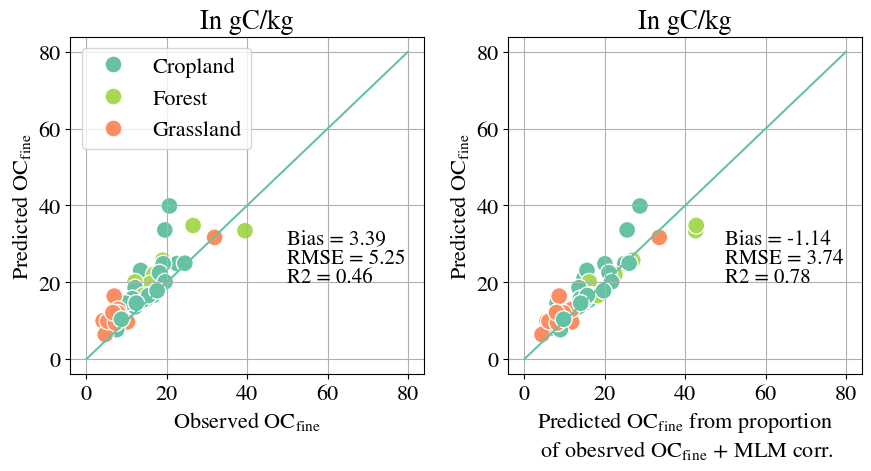

In [12]:
# Apply correction
data_rabot['prop_MAOC_rabot'] = (data_rabot['rabot_c_maom'] / data_rabot['carbone'])*100
data_rabot['prop_POC_rabot'] = 100 - data_rabot['prop_MAOC_rabot']
data_rabot.loc[data_rabot['dispersion'] == 'W','prop_POC_corrected'] = data_rabot[data_rabot['dispersion'] == 'W']['prop_POC'] + method_correction_m3m1 + data_rabot[data_rabot['dispersion'] == 'W']['pH']*ph_correction_m3m1

data_rabot['c_maoc_rabot'] = (data_rabot['prop_MAOC_rabot']/100) * data_rabot['carbone']
data_rabot['c_maoc_corrected'] = (100 - data_rabot['prop_POC_corrected'])/100 * data_rabot['carbone']
df = data_rabot[data_rabot['dispersion'] == 'W'].copy()


# Plot results
fix, axes = plt.subplots(1,2,figsize=(9,5))
axes = axes.ravel()

sns.scatterplot(data=df, x='c_maom', y='rabot_c_maom',hue='clc_group', s=150, ax=axes[0])
sns.lineplot(x=[0,80], y=[0,80], ax=axes[0])
axes[0].set_title('In gC/kg')
axes[0].text(50,20, 'R2 = {:.2f}'.format(r2_score(df['c_maom'], df['rabot_c_maom'])), fontsize=15)
axes[0].text(50,25, 'RMSE = {:.2f}'.format(np.sqrt(mean_squared_error(df['c_maom'], df['rabot_c_maom']))), fontsize=15)
axes[0].text(50,30, 'Bias = {:.2f}'.format(bias_function(df['c_maom'], df['rabot_c_maom'])), fontsize=15)
axes[0].set_xlabel('Observed OC$_\mathrm{fine}$')
axes[0].set_ylabel('Predicted OC$_\mathrm{fine}$')

sns.scatterplot(data=df, x='c_maoc_corrected', y='c_maoc_rabot', ax=axes[1], hue='clc_group', s=150)
sns.lineplot(x=[0,80], y=[0,80], ax=axes[1])
axes[1].legend('', frameon=False)
axes[1].set_title('In gC/kg')
axes[1].legend('', frameon=False)

axes[1].text(50,20, 'R2 = {:.2f}'.format(r2_score(df['c_maoc_rabot'], df['c_maoc_corrected'])), fontsize=15)
axes[1].text(50,25, 'RMSE = {:.2f}'.format(np.sqrt(mean_squared_error(df['c_maoc_rabot'], df['c_maoc_corrected']))), fontsize=15)
axes[1].text(50,30, 'Bias = {:.2f}'.format(bias_function(df['c_maoc_rabot'], df['c_maoc_corrected'])), fontsize=15)
axes[1].set_ylabel('Predicted OC$_\mathrm{fine}$')
axes[1].set_xlabel('Predicted OC$_\mathrm{fine}$ from proportion \n of obesrved OC$_\mathrm{fine}$ + MLM corr. ')


axes[0].grid(visible=True)
axes[1].grid(visible=True)

plt.tight_layout()
# plt.savefig('output/rabot/rabot_application.png')

## **Relationships between methods and predictors**

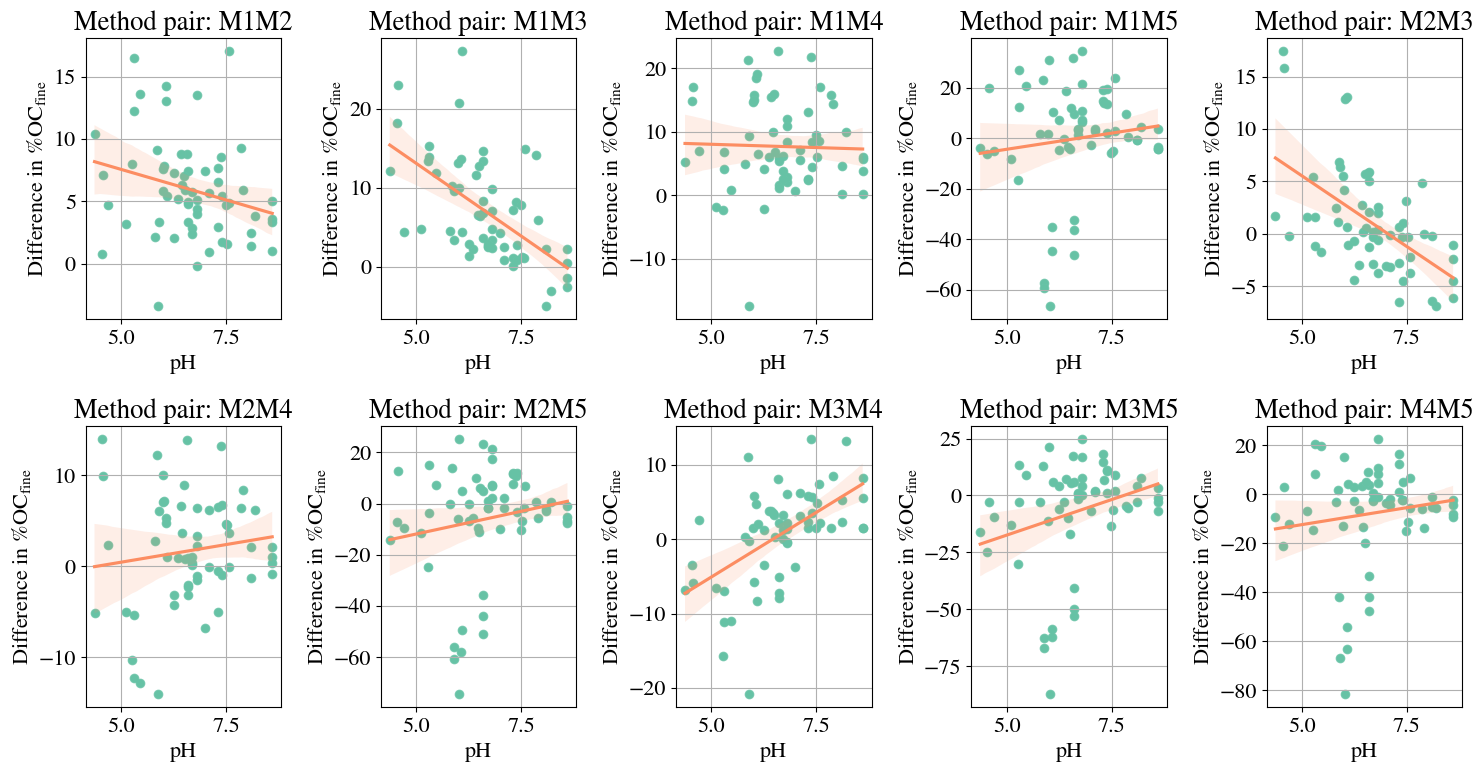

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to add regression equation to the plot
def add_regression_eq(ax, model, x=0.5, y=0.9):
    slope, intercept = model.params[1], model.params[0]
    equation = f'y = {slope:.3f}x + {intercept:.3f}'
    ax.text(x, y, equation, transform=ax.transAxes, fontsize=14, ha='center', va='top', color=colors[2])

# Assuming 'protocol_combination' has 10 unique values
unique_protocols = df_compare_combined['protocol_combination'].unique()

# Create a 2x5 grid of subplots (adjust the number of rows and columns as needed)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 8))  # Adjust figure size as necessary

axes = axes.flatten()

# Loop through each unique protocol combination and plot on the corresponding subplot
for i, protocol in enumerate(unique_protocols):
    ax = axes[i]
    sns.scatterplot(
        data=df_compare_combined[df_compare_combined['protocol_combination'] == protocol],
        x='pH',
        y='diff',
        # style='ph_outlier',
        # hue='ph_outlier',
        ax=ax  # Assign the plot to the corresponding subplot
    )
    X = sm.add_constant(df_compare_combined[df_compare_combined['protocol_combination'] == protocol]['pH'])
    y = df_compare_combined[df_compare_combined['protocol_combination'] == protocol]['diff']
    model = sm.OLS(y, X).fit()

    # Plot the relationship between the predictor and prop_POC for the current method
    sns.regplot(data=df_compare_combined[df_compare_combined['protocol_combination'] == protocol],
                x='pH',
                y='diff',
                # hue='pH',
                line_kws={'color': colors[2]},
                ax=ax,)  # Assign the plot to the corresponding subplot
                # line_kws={'color': colors[1]}, ax=ax)

    # Add regression equation
    # if (i == 2) or (i == 1) :
    #     add_regression_eq(ax, model, 'pH', x=0.5, y=0.15)
    # # else:
    #     add_regression_eq(ax, model, 'pH')

    ax.set_title(f'Method pair: {protocol}')
    ax.set_xlabel('pH')
    ax.set_ylabel('Difference in %OC$_\mathrm{fine}$')
    ax.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
